


# Downloads and model classes

In [1]:
!pip install svgwrite
import numpy as np
import tensorflow as tf
import sys

     |████████████████████████████████| 66 kB 2.0 MB/s 


In [2]:
#!/usr/bin/env python3

import numpy as np
import tensorflow as tf

def positional_encoding(max_seq_len, dm):
    """
    Calculates the positional encoding for a transformer
    max_seq_len: integer representing the maximum sequence length
    dm: integer representing the model depth
    Returns: numpy.ndarray of shape (max_seq_len, dm) containing the positional
             encoding vectors
    """
    PE = np.zeros((max_seq_len, dm))
    for row in range(max_seq_len):
        for col in range(0, dm, 2):
            PE[row, col] = np.sin(row / (10000 ** (col / dm)))
            PE[row, col + 1] = np.cos(row / (10000 ** (col / dm)))
    return PE


def sdp_attention(Q, K, V, mask=None):
    """
    Q: tensor with shape (..., seq_len_q, dk) containing the query matrix
    K: tensor with shape (..., seq_len_v, dk) containing the key matrix
    V: tensor with shape (..., seq_len_v, dv) containing the value matrix
    mask: tensor that can be broadcast into (..., seq_len_q, seq_len_v)
          containing the optional maask, or defaulted to None
    The Preceding dimensions of Q, K, and V are the same
    Returns: output, weights
             output: tensor with shape (..., seq_len_q, dv) containing the dot
                     product attention
             weights: tensor with shape (..., seq_len_q, seq_len_v) containing
                      the attention weights
    """
    # Matmul Q and K
    QK = tf.matmul(Q, K, transpose_b=True)

    # Scale the dot product
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled = QK / tf.math.sqrt(dk)

    # Add mask if not None
    if mask is not None:
        scaled += mask * -1e9

    # Pass scaled attention through softmax activation
    weights = tf.nn.softmax(scaled, axis=-1)

    # Matmul by value matrix for output
    output = tf.matmul(weights, V)

    return output, weights


class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Class to perform multi head attention
    """
    def __init__(self, dm, h):
        """
        dm: integer representing the model dimensionality
        h: integer representing the number of heads
        dm is divisible by h
        """
        super(MultiHeadAttention, self).__init__()
        self.h = h
        self.dm = dm
        self.depth = dm // self.h
        self.Wq = tf.keras.layers.Dense(dm)
        self.Wk = tf.keras.layers.Dense(dm)
        self.Wv = tf.keras.layers.Dense(dm)
        self.linear = tf.keras.layers.Dense(dm)

    def split_heads(self, x, batch_size):
        """
        Splits the last dimension of tensor x into (h, depth)
        Transpose the result such that the shape is
        (batch_size, h, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.h, self.depth))
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return x

    def call(self, Q, K, V, mask):
        """
        Q: tensor with shape (..., seq_len_q, dk) containing the query matrix
        K: tensor with shape (..., seq_len_v, dk) containing the key matrix
        V: tensor with shape (..., seq_len_v, dv) containing the value matrix
        mask: always None
        The Preceding dimensions of Q, K, and V are the same
        Returns: output, weights
                 output: tensor with shape (..., seq_len_q, dv) containing the
                         dot product attention
                 weights: tensor with shape (..., seq_len_q, seq_len_v)
                          containing the attention weights
        """
        batch_size = tf.shape(Q)[0]

        # Generate query, key, and value matrices
        Q = self.Wq(Q)
        K = self.Wk(K)
        V = self.Wv(V)

        # Split between heads
        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        # Scaled Dot Product Attention
        attention, weights = sdp_attention(Q, K, V, mask)

        # Refit to pass through linear layer
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        attention = tf.reshape(attention, (batch_size, -1, self.dm))
        output = self.linear(attention)

        return output, weights


class DecoderBlock(tf.keras.layers.Layer):
    """
    Class representation of a decoder block for a transformer
    """
    def __init__(self, dm, h, hidden, drop_rate=0.1, name=None):
        """
        dm: Dimensionality of the model
        h: Number of heads
        hidden: Number of hidden units in the fully connected layer
        drop_rate: Dropout rate
        """
        super(DecoderBlock, self).__init__()
        if name is not None:
            self._name = name
        self.mha1 = MultiHeadAttention(dm, h)
        self.dense_hidden = tf.keras.layers.Dense(
            units=hidden,
            activation='relu'
        )
        self.dense_output = tf.keras.layers.Dense(units=dm)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(drop_rate)
        self.dropout2 = tf.keras.layers.Dropout(drop_rate)

    def call(self, inputs, look_ahead_mask, training=False):
        """
        x: tensor of shape (batch, target_seq_len, dm)containing the input to
           the decoder block
        training: boolean to determine if the model is training
        look_ahead_mask: mask to be applied to the first multi head attention
                         layer
        Returns: tensor of shape (batch, target_seq_len, dm) containing the
                 block's output
        """
        # Pass through MHA and dropout layer
        attn_out, _ = self.mha1(inputs, inputs, inputs, look_ahead_mask)
        attn_out = self.dropout1(attn_out, training=training)

        # Add and normalize
        out = self.layernorm1(inputs + attn_out)

        # Pass through dense layers and dropout layer
        dense_output = self.dense_hidden(out)
        dense_output = self.dense_output(dense_output)
        dense_output = self.dropout2(dense_output, training=training)

        # Add and normalize
        out = self.layernorm2(out + dense_output)

        return out


class Decoder(tf.keras.Model):
    """
    Class representation of a decoder for a transformer
    """
    def __init__(self, Nb, No, Np, dm, h, hidden, max_seq_len,
                 drop_rate=0.1):
        """
        Nb - number of blocks in the base of the model
        No - number of blocks in the x/y offset branch
        Np - number of blocks in the pen state prediction branch
        dm - the dimensionality of the model
        h - the number of heads
        hidden - the number of hidden units in the fully connected layer
        max_seq_len - the maximum sequence length possible
        drop_rate - the dropout rate
        """
        super(Decoder, self).__init__()
        self.Nb = Nb
        self.No = No
        self.Np = Np
        self.dm = dm
        self.projection = tf.keras.layers.Dense(dm, name='base_projection')
        self.positional_encoding = positional_encoding(max_seq_len, dm)
        self.dropout = tf.keras.layers.Dropout(drop_rate)

        self.base_blocks = [
            DecoderBlock(dm, h, hidden, drop_rate,
            name="base_block_" + str(n)) for n in range(Nb)
        ]
        self.offset_blocks = [
            DecoderBlock(dm, h, hidden, drop_rate,
            name="offset_block_" + str(n)) for n in range(No)
        ]
        self.pen_blocks = [
            DecoderBlock(dm, h, hidden, drop_rate,
            name="pen_block_" + str(n)) for n in range(Np)
        ]

        self.offset_dense = tf.keras.layers.Dense(dm, name='offset_dense')
        self.offset_out = tf.keras.layers.Dense(2, name='offset_out')
        self.pen_dense = tf.keras.layers.Dense(dm, name='pen_dense')
        self.pen_out = tf.keras.layers.Dense(3, name='pen_out',
                                             activation='softmax')

    def call(self, inputs, look_ahead_mask=None, training=False):
        """
        x - a tensor of shape (batch, target_seq_len, dm) containing the input
            to the decoder
        encoder_output - a tensor of shape (batch, input_seq_len, dm)
            containing the output of the encoder
        training - a boolean to determine if the model is training
        look_ahead_mask - the mask to be applied to the first multi head
            attention layer
        padding_mask - the mask to be applied to the second multi head
            attention layer
        Returns: a tensor of shape (batch, target_seq_len, dm) containing the
            decoder output
        """
        seq_len = int(inputs.shape[1])

        # Project to model dimension
        x = self.projection(inputs)

        # Add positional encoding and pass through dropout layer
        x *= tf.math.sqrt(tf.cast(self.dm, 'float32'))
        x += self.positional_encoding[:seq_len]
        x = self.dropout(x, training=training)

        # Pass through base decoder blocks
        for block in self.base_blocks:
            x = block(x, look_ahead_mask, training)

        # Pass through offset branch
        offset = x
        for block in self.offset_blocks:
            offset = block(offset, look_ahead_mask, training)
        offset = self.offset_dense(offset)
        offset = self.offset_out(offset)

        pen = x
        for block in self.pen_blocks:
            pen = block(pen, look_ahead_mask, training)
        pen = self.pen_dense(pen)
        pen = self.pen_out(pen)

        return offset, pen


# dataset class

In [8]:
# Function from utils.py for sketch-rnn in the Magenta github repository
# at https://github.com/magenta/magenta/tree/main/magenta/models/sketch_rnn
def to_big_strokes(stroke, max_len=250):
  """Converts from stroke-3 to stroke-5 format and pads to given length."""
  # (But does not insert special start token).

  result = np.zeros((max_len, 5), dtype=float)
  l = len(stroke)
  assert l <= max_len
  result[0:l, 0:2] = stroke[:, 0:2]
  result[0:l, 3] = stroke[:, 2]
  result[0:l, 2] = 1 - result[0:l, 3]
  result[l:, 4] = 1
  return result

# Tokenizing isn't being used anymore but these functions are being kept
# until we're absolutely certain we don't need them

def strokes_to_tokens(strokes):
    """
    strokes is a 2d numpy array of stroke-5 vectors to be converted into tokens
    Returns a list of the tokenized vectors
    """
    tokens = []
    for stroke in strokes:
        token = (stroke[0] + 255) * 511
        token += (stroke[1] + 255)
        token += np.sum(np.array([100, 500000, 1000000]) * stroke[2:])
        tokens.append(token)
    return np.asarray(tokens)

def tokens_to_strokes(tokens):
    """
    tokens is a 1d numpy array of stroke tokens to be converted into strokes
    Returns a list of the strokes
    """
    strokes = []
    for token in tokens:
        stroke = [0] * 5
        if token // 1000000 == 1:
            stroke[4] = 1
            token -= 1000000
        elif token // 500000 == 1:
            stroke[3] = 1
            token -= 500000
        else:
            stroke[2] = 1
            token -= 100
        stroke[0] = token // 511 - 255
        stroke[1] = token % 511 - 255
        strokes.append(stroke)
    return np.asarray(strokes)


def clean(data, max_length=100):
    """
    Data is a np 3d array of samples in stroke-3 format
    Removes all samples with length > max_length
    Converts to stroke-5 and pads to max_length
    Tokenizes stroke-5 vectors
    Scales offsets down by a factor of eight and rounds
    Returns tokenized dataset as a np 2d array
    """
    dataset = []
    for sample in data:
        if len(sample) <= max_length:
            sample = to_big_strokes(sample, max_length)
            dataset.append(sample)
    dataset = np.asarray(dataset)
    #dataset[:, :, :2] /= 8
    #dataset = np.round(dataset)
    return dataset


def offset_to_absolute(data):
    """
    Converts stroke-5 format vectors from
        [x_offset, y_offset, pen_down, pen_up, drawing_done]
    to
        [x_absolute, y_absolute, pen_down, pen_up, drawing_done]
    """
    result = np.copy(data)
    result[:, 0, :2] = [120, 68]
    for i in range(1, data.shape[1]):
        result[:, i, 0] += result[:, i - 1, 0]
        result[:, i, 1] += result[:, i - 1, 1]

    return result

class Dataset:
    """ Document later """

    def __init__(self, filepath, batch_size=32, max_length=250):
        """ Init """
        data = np.load(
            filepath,
            encoding='latin1',
            allow_pickle=True
        )

        # Clean up dataset, removing samples over max_length
        # and tokenizing
        self.train = clean(data['train'])
        self.valid = clean(data['valid'])
        self.test = clean(data['test'])

        # Convert to tensorflow datasets for training
        self.train = tf.convert_to_tensor(self.train)
        self.train = tf.data.Dataset.from_tensor_slices(list(self.train))
        self.valid = tf.convert_to_tensor(self.valid)
        self.valid = tf.data.Dataset.from_tensor_slices(list(self.valid))
        self.test = tf.convert_to_tensor(self.test)
        self.test = tf.data.Dataset.from_tensor_slices(list(self.test))

        # Shuffle and batch train and valid sets
        self.train = self.train.shuffle(max_length)
        self.valid = self.valid.shuffle(max_length)
        self.train = self.train.batch(batch_size)
        self.valid = self.valid.batch(batch_size)


# Training

In [5]:
# to do list for training
# break dataset into batches
# mask off parts for sets
# create loss function

# Dataset = __import__('3-dataset').Dataset
# create_masks = __import__('4-create_masks').create_masks
# Transformer = __import__('5-transformer').Transformer
def train_transformer(Nb, No, Np, dm, h, hidden, max_len, batch_size, epochs):
    """ creates and trains a transformer model for machine translation
          of portuguese to English
        Nb - number of blocks in the base of the model
        No - number of blocks in the x/y offset branch
        Np - number of blocks in the pen state prediction branch
        dm: dimensionality of the model
        h: number of heads
        hidden: number of hidden units in fc layers
        max_len: max tokens per sequence
        batch_size: batch size for training
        epochs: number of epochs
        adam opt (beta1=0.9, beta2=0.98, epsilon=1e-9)
        also special learning rat eequation
        sparse categorical crossentropy
        Returns: the trained model
    """

    def create_labels(data):
        """
        Creates labels for a stroke-5 format dataset
        Each sample of size (?, 5) creates 3 one-hot labels of size (?, 481),
        (?, 271), and (?, 3) for x offset, y offset, and pen state probabilities
        respectively
        Returns x_labels, y_labels, and pen_labels
        """
        x_labels = np.zeros(data.shape[:2] + (481,))
        y_labels = np.zeros(data.shape[:2] + (271,))

        pen_labels = data[:, :, 2:]

        for i, sample in enumerate(data[:16]):
            for j, point in enumerate(sample):
                x_labels[i, j, int(data[i, j, 0]) + 240] = 1
                y_labels[i, j, int(data[i, j, 1]) + 135] = 1

        x_labels = tf.convert_to_tensor(x_labels)
        y_labels = tf.convert_to_tensor(y_labels)
        pen_labels = tf.convert_to_tensor(pen_labels)

        return [x_labels, y_labels, pen_labels]

    def create_mask(batch_size, seq_len):
        """
        Creates the look mask for attention in the decoder
        seq_len: Length of the sequence for which to make the mask
        """
        
        mask = 1 - tf.linalg.band_part(tf.ones((1, 1, seq_len, seq_len)), -1, 0)
        return mask


    offset_loss_ = tf.keras.losses.MeanSquaredError()
    pen_loss_ = tf.keras.losses.CategoricalCrossentropy()

    def loss_function(real, offsets, pen_states):
        """ custom loss function for transformer 
            real are real values of output
            pred: output of the model
        """

        offset_loss = offset_loss_(real[:, :, :2], offsets)
        pen_loss = pen_loss_(real[:, :, 2:], pen_states)

        return offset_loss, pen_loss

      # can cast if necessary like so
      # mask = tf.cast(mask, dtype=loss_.dtype)
      # loss_ *= mask
      # do we still need to / by reduced sum

    # create dataset
    data = Dataset('cat.npz', batch_size=batch_size)
    
    # then create transformer
    transformer = Decoder(Nb, No, Np, dm, h, hidden, max_len)

    # Run a dummy set of inputs through to initialize weights
    # and create lists of weights to apply gradients to
    # Done to separate loss between offset and pen state branches
    inputs = np.random.uniform(size=(1, 100, 5))
    transformer(inputs, None)

    offset_weights = []
    pen_weights = []
    for weight in transformer.trainable_weights:
        if "base" in weight.name:
            offset_weights.append(weight)
            pen_weights.append(weight)
        if "offset" in weight.name:
            offset_weights.append(weight)
        if "pen" in weight.name:
            pen_weights.append(weight)

    # set some hyper param stuff
    pen_train_loss = tf.keras.metrics.Mean(name='pen_train_loss')
    offset_train_loss = tf.keras.metrics.Mean(name='offset_train_loss')
    learning_rate = CustomSchedule(dm)
    #learning_rate = 0.001
    offset_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                name='offset optimizer')
    pen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                             name='pen_optimizer')
    
    def train_step(inputs):
        """ single train step 
            takes in input and a target value
        """
        mask = create_mask(batch_size, max_len - 1)

        with tf.GradientTape(persistent=True) as tape:
            offsets, pen_states = transformer(inputs[:, :-1], mask, True)

            # must also take third arg for this loss f'n
            # loss = loss_function(tar_real, predictions)
            offset_loss, pen_loss = loss_function(inputs[:, 1:], offsets, pen_states)

        grads = tape.gradient(offset_loss, offset_weights)
        offset_optimizer.apply_gradients(zip(grads, offset_weights))
        grads = tape.gradient(pen_loss, pen_weights)
        pen_optimizer.apply_gradients(zip(grads, pen_weights))
        offset_train_loss(offset_loss)
        pen_train_loss(pen_loss)
        del tape

    offset_losses = []
    pen_losses = []

    # then do the training
    for epoch in range(epochs):
        offset_train_loss.reset_states()
        pen_train_loss.reset_states()
        for batch, inp in enumerate(data.train):
            train_step(inp)

            offset_losses.append(offset_train_loss.result())
            pen_losses.append(pen_train_loss.result())

            if batch % 50 == 0:
                if batch % 50 == 0:
                    print("Epoch {}, batch {}: Offset Loss: {} Pen Loss {}".format(
                        epoch + 1,
                        batch,
                        offset_train_loss.result(),
                        pen_train_loss.result()
                    ))
        print("Epoch {}: Offset Loss: {} Pen Loss {}".format(
            epoch + 1,
            offset_train_loss.result(),
            pen_train_loss.result()
        ))
        transformer.save_weights('epoch_' + str(epoch))

        if epoch % 5 == 0 and epoch > 0:
            learning_rate /= 2

    return transformer, offset_losses, pen_losses


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """ Custom learning rate schedule """
    def __init__(self, d_model, warmup_steps=4000):
        """ Init """
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        """ Call """
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Epoch 1, batch 0: Offset Loss: 1149.0440673828125 Pen Loss 1.4293053150177002
Epoch 1, batch 50: Offset Loss: 1137.49267578125 Pen Loss 1.0188302993774414
Epoch 1, batch 100: Offset Loss: 1122.8873291015625 Pen Loss 0.7536736130714417
Epoch 1, batch 150: Offset Loss: 1096.431396484375 Pen Loss 0.6182723045349121
Epoch 1, batch 200: Offset Loss: 1070.9224853515625 Pen Loss 0.543330729007721
Epoch 1, batch 250: Offset Loss: 1053.44482421875 Pen Loss 0.49598929286003113
Epoch 1, batch 300: Offset Loss: 1042.2706298828125 Pen Loss 0.46370425820350647
Epoch 1, batch 350: Offset Loss: 1032.1123046875 Pen Loss 0.4403620958328247
Epoch 1, batch 400: Offset Loss: 1018.4906005859375 Pen Loss 0.421571284532547
Epoch 1, batch 450: Offset Loss: 1009.6517944335938 Pen Loss 0.40669819712638855
Epoch 1, batch 500: Offset Loss: 1000.5267944335938 Pen Loss 0.39469626545906067
Epoch 1, batch 550: Offset Loss: 993.4723510742188 Pen Loss 0.38477960228919983
Epoch 1, batch 600: Offset Loss: 986.48095703125 

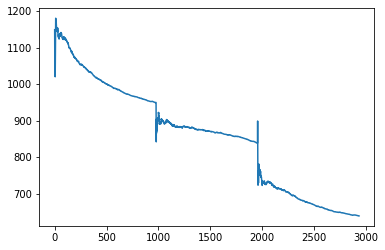

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# from transformer import Encoder
# from utils import to_big_strokes
# from dataset import Dataset

model, offset_losses, pen_losses = train_transformer(4, 2, 2, 256, 8, 512, 100, 64, 3)

offset_losses = [tf.reduce_sum(loss).numpy() for loss in offset_losses]

plt.plot(range(len(offset_losses)), offset_losses)
plt.show()

model.save_weights('branched_5_epoch.h5')


[[-18.   5.   1.   0.   0.]
 [-15.  16.   1.   0.   0.]
 [ -7.  13.   1.   0.   0.]
 [ -1.  36.   1.   0.   0.]
 [  9.  15.   1.   0.   0.]
 [ 28.  26.   1.   0.   0.]
 [ 13.   4.   1.   0.   0.]
 [ 29.  -1.   1.   0.   0.]
 [ 32. -15.   1.   0.   0.]
 [ 24. -22.   1.   0.   0.]
 [ 11. -16.   1.   0.   0.]
 [  3. -10.   1.   0.   0.]
 [ -2. -23.   1.   0.   0.]
 [-12. -18.   1.   0.   0.]
 [-24. -12.   1.   0.   0.]
 [-21.  -3.   1.   0.   0.]
 [-48.   0.   1.   0.   0.]
 [-19.   9.   0.   1.   0.]
 [ 11.   9.   1.   0.   0.]
 [  2. -10.   1.   0.   0.]
 [  0. -24.   1.   0.   0.]
 [  8.  -3.   1.   0.   0.]
 [ 17.  12.   1.   0.   0.]
 [ 21.  22.   1.   0.   0.]
 [ 15.  11.   0.   1.   0.]
 [ 38.   0.   1.   0.   0.]
 [ 22. -18.   1.   0.   0.]
 [  6.   3.   1.   0.   0.]
 [ -3.  25.   1.   0.   0.]
 [ -9.  28.   0.   1.   0.]
 [-83.  30.   1.   0.   0.]
 [ -2.   8.   1.   0.   0.]
 [  2.   5.   1.   0.   0.]
 [  4.   1.   1.   0.   0.]
 [  3.  -3.   1.   0.   0.]
 [ -1.  -5.   1.   0

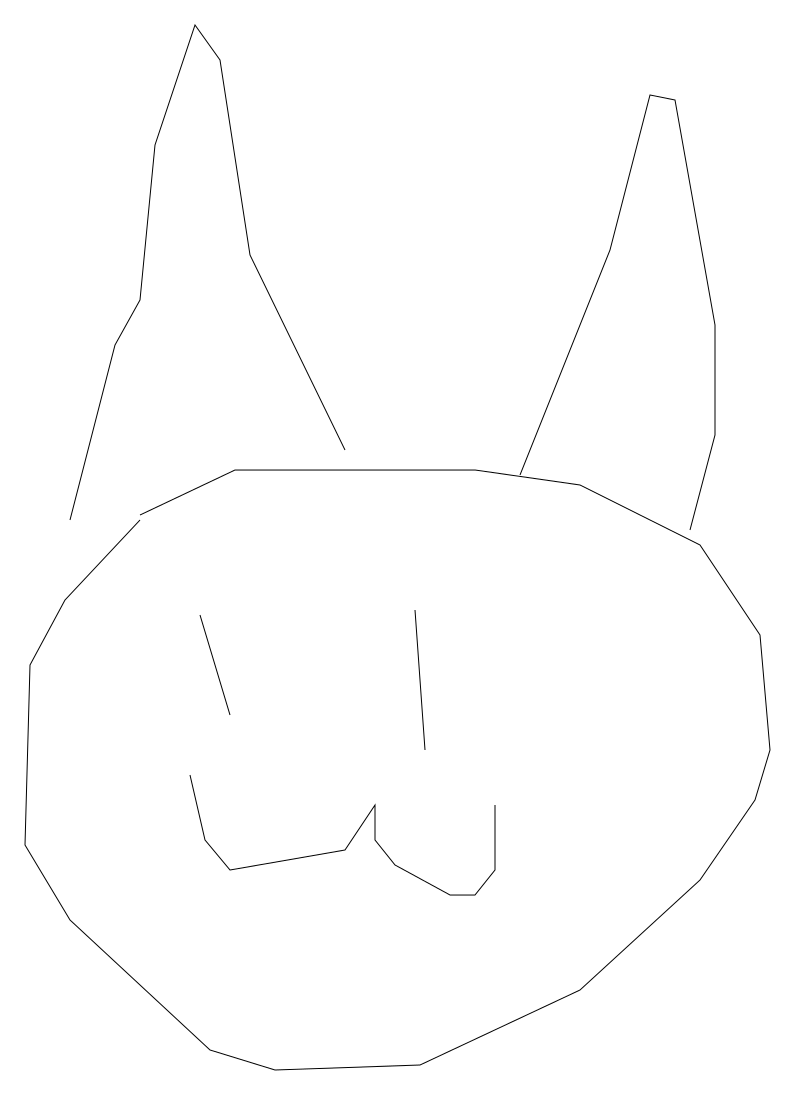

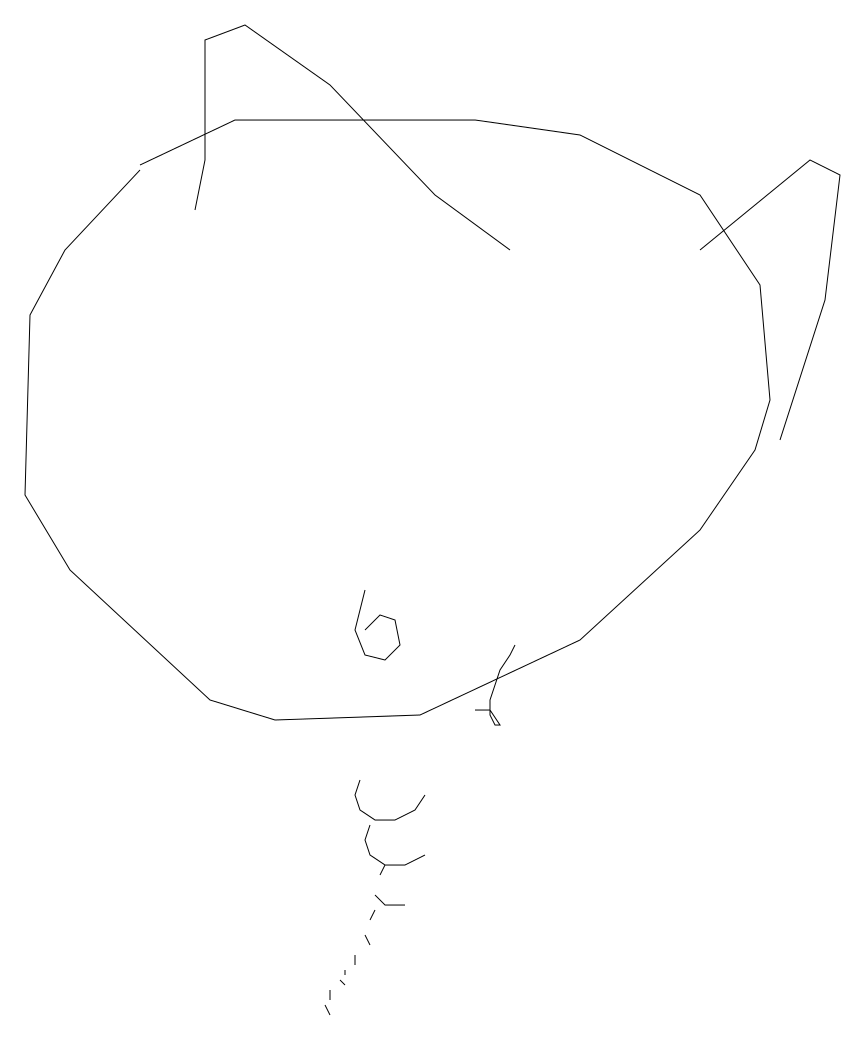

In [15]:
### this is our test file for fisplay after training
# test = data['train'][4]

def offset_to_absolute(data):
    """
    Converts stroke-5 format vectors from
        [x_offset, y_offset, pen_down, pen_up, drawing_done]
    to
        [x_absolute, y_absolute, pen_down, pen_up, drawing_done]
    """
    result = np.copy(data)
    result[:, 0, :2] = [120, 68]
    for i in range(1, data.shape[1]):
        result[:, i, 0] += result[:, i - 1, 0]
        result[:, i, 1] += result[:, i - 1, 1]

    return result

def to_big_strokes(stroke, max_len=100):
    """Converts from stroke-3 to stroke-5 format and pads to given length."""
    # (But does not insert special start token).

    result = np.zeros((max_len, 5), dtype=float)
    l = len(stroke)
    assert l <= max_len
    result[0:l, 0:2] = stroke[:, 0:2]
    result[0:l, 3] = stroke[:, 2]
    result[0:l, 2] = 1 - result[0:l, 3]
    result[l:, 4] = 1
    return result


def create_mask(batch_size, seq_len):
        """
        Creates the look mask for attention in the decoder
        seq_len: Length of the sequence for which to make the mask
        """
        
        mask = 1 - tf.linalg.band_part(tf.ones((1, 1, seq_len, seq_len)), -1, 0)
        return mask

def create_labels(data):
    """
    Creates labels for a stroke-5 format dataset
    Each sample of size (?, 5) creates 3 one-hot labels of size (?, 481),
    (?, 271), and (?, 3) for x offset, y offset, and pen state probabilities
    respectively
    Returns x_labels, y_labels, and pen_labels
    """
    x_labels = np.zeros(data.shape[:2] + (481,))
    y_labels = np.zeros(data.shape[:2] + (271,))

    pen_labels = data[:, :, 2:]

    for i, sample in enumerate(data):
        for j, point in enumerate(sample):
            x_labels[i, j, int(data[i, j, 0]) + 240] = 1
            y_labels[i, j, int(data[i, j, 1]) + 135] = 1

    x_labels = tf.convert_to_tensor(x_labels)
    y_labels = tf.convert_to_tensor(y_labels)
    pen_labels = tf.convert_to_tensor(pen_labels)

    return [x_labels, y_labels, pen_labels]


data = np.load('cat.npz', encoding='latin1', allow_pickle=True)
test = data['test'][4]
test = to_big_strokes(test)
test[:, :2] = test[:, :2]
inputs = test[np.newaxis, :18]

while inputs[0, -1, -1] != 1 and inputs.shape[1] < 100:
    mask = create_mask(1, inputs.shape[1])
    offsets, pen_states = model(inputs, mask)
    offsets = np.round(offsets)
    pen_states = np.round(pen_states)
    pred = np.concatenate((offsets[0, -1], pen_states[0, -1]))
    inputs = np.concatenate((inputs, pred.reshape(1, 1, 5)), axis=1)

print(inputs[0])

draw_strokes(test, svg_filename='realcat.svg')
draw_strokes(inputs[0], svg_filename="cat.svg")


# drawing dependencies

In [10]:
# libraries required for visualisation:
import os
import svgwrite
import numpy as np
import tensorflow as tf
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt
# import data_Manager
import math
from matplotlib import animation

# data_Manager = Data
# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)


def get_bounds(data, factor=10):
    """Return bounds of data."""
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)


def slerp(p0, p1, t):
    """Spherical interpolation."""
    omega = np.arccos(np.dot(p0 / np.linalg.norm(p0), p1 / np.linalg.norm(p1)))
    so = np.sin(omega)
    return np.sin((1.0 - t) * omega) / so * p0 + np.sin(t * omega) / so * p1


def lerp(p0, p1, t):
    """Linear interpolation."""
    return (1.0 - t) * p0 + t * p1


def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:, 0:2] = big_stroke[0:l, 0:2]
    result[:, 2] = big_stroke[0:l, 3]
    return result


# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
    # data = data_Manager.to_normal_strokes(data)
    data = to_normal_strokes(data)
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))


"""
Function for animate drawing. 
taken from 
https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/Strokes_QuickDraw.ipynb#scrollTo=0ABX6O4kYwYS
"""
def create_animation(drawing, fps = 30, idx = 0, lw = 5): 
  
  seq_length = 0 
  
  xmax = 0 
  ymax = 0 
  
  xmin = math.inf
  ymin = math.inf
  
  #retreive min,max and the length of the drawing  
  for k in range(0, len(drawing)):
    x = drawing[k][0]
    y = drawing[k][1]

    seq_length += len(x)
    xmax = max([max(x), xmax]) 
    ymax = max([max(y), ymax]) 
    
    xmin = min([min(x), xmin]) 
    ymin = min([min(y), ymin]) 
    
  i = 0 
  j = 0
  
  # First set up the figure, the axis, and the plot element we want to animate
  fig = plt.figure()
  ax = plt.axes(xlim=(xmax+lw, xmin-lw), ylim=(ymax+lw, ymin-lw))
  ax.set_facecolor("white")
  line, = ax.plot([], [], lw=lw)

  #remove the axis 
  ax.grid = False
  ax.set_xticks([])
  ax.set_yticks([])
  
  # initialization function: plot the background of each frame
  def init():
      line.set_data([], [])
      return line, 

  # animation function.  This is called sequentially
  def animate(frame):    
    nonlocal i, j, line
    x = drawing[i][0]
    y = drawing[i][1]
    line.set_data(x[0:j], y[0:j])
    
    if j >= len(x):
      i +=1
      j = 0 
      line, = ax.plot([], [], lw=lw)
      
    else:
      j += 1
    return line,
  
  # call the animator.  blit=True means only re-draw the parts that have changed.
  anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames= seq_length + len(drawing), blit=True)
  plt.close()
  
  # save the animation as an mp4.  
  anim.save(f'video.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

In [ ]:
import urllib.request
import glob
import os
import numpy as np
# from HyperParameters import HP
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import Callback


HP = hyper_parameters
class Data():
    # managing the data
    def __init__(self, size = None):
        'Initialization'
        # first load the data
        self.loadData(size)
        self.dim = HP.input_dimention
        self.batch_size = HP.batch_size
        self.train = purify(self.train)
        self.valid = purify(self.valid)
        self.test = purify(self.test)
        self.train = self.normalize(self.train)
        self.valid = self.normalize(self.valid)
        self.test = self.normalize(self.test)
        self.train = np.array(self.train)
        self.valid = np.array(self.valid)
        self.test = np.array(self.test)
    

    def loadData(self, size):  
        npzFile = np.load(HP.data_location, allow_pickle=True, encoding='latin1')
        train = npzFile['train']
        if size:
            self.train = np.copy(train[:size])
        else:
            self.train = train
        self.trainDimention = len(self.train)
        
        self.test = npzFile['test']
        
        self.valid = npzFile['valid']
        self.validationDimention = len(self.valid)
        return self.train, self.valid, self.test

    def calculate_normalizing_scale_factor(self, strokes):
        """Calculate the normalizing factor explained in appendix of sketch-rnn."""
        data = []
        for i in range(len(strokes)):
            if len(strokes[i]) > HP.max_seq_length:
                continue
            for j in range(len(strokes[i])):
                data.append(strokes[i][j, 0])
                data.append(strokes[i][j, 1])
        data = np.array(data)
        return np.std(data)

    def normalize(self, strokes,  scale_factor=None):
        """Normalize entire dataset (delta_x, delta_y) by the scaling factor."""
        if scale_factor is None:
            scale_factor = self.calculate_normalizing_scale_factor(strokes)
        self.scale_factor = scale_factor
        for i in range(len(strokes)):
            strokes[i][:, 0:2] /= self.scale_factor
        return strokes

def purify(strokes):
    # We have to remove too long sequence 
    data = []
    for seq in strokes:
        if seq.shape[0] <= HP.max_seq_length:
            len_seq = len(seq[:,0])
            # pen state made by 3 state
            new_seq = np.zeros((HP.max_seq_length,5))
            new_seq[:len_seq,:2] = seq[:,:2]
            new_seq[:len_seq-1,2] = 1-seq[:-1,2]
            new_seq[:len_seq,3] = seq[:,2]
            new_seq[len_seq:,4] = 1
            data.append(new_seq)
    return data



def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:, 0:2] = big_stroke[0:l, 0:2]
    result[:, 2] = big_stroke[0:l, 3]
    return result

# see https://keras.io/utils/ for more info
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, Data, shuffle=True, validation = False):
        'Initialization'
        self.Data = Data
        self.validation = validation
        if validation:
            self.batch_size = len(Data)
        else:
            self.batch_size = HP.batch_size
        self.dimention = len(Data)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.validation:
            return 1    
        return int(np.floor(self.dimention/ self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        encoder_input = self.Data[indexes]
        #if not self.validation:
            #encoder_input = self.dataAugmentation(encoder_input)
        decoder_ipnut = create_decoder_input(encoder_input)
        """
        encoder_ipnut_short = []
        for i in range(encoder_input.shape[0]):
            for j in range(encoder_input.shape[1]):
                if encoder_input[i,j,4] == 1:
                    encoder_ipnut_short.append(np.copy(encoder_input[i, :j, :]))
                    break
        """
        
        return [encoder_input, decoder_ipnut], [encoder_input]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.dimention)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def dataAugmentation(self, strokes):
        # generate random uniform between 0.9 to 1.1
        randomx = np.random.rand()*(0.1)+1.
        randomy = np.random.rand()*(0.1)+1.
        # multiply the 
        strokes[:,:,0] = strokes[:,:,0]*randomx
        strokes[:,:,1] = strokes[:,:,1]*randomy
        return strokes     

def create_decoder_input(sequence):
    """
    function that, given an input sequence returns another sequence 
    for the decoder. 
    It shift the old sequence by one and insert on head the value
    (0,0,1,0,0)
    """
    decoder_ipnut = np.zeros(shape=sequence.shape)
    # copy the value of the sequence
    decoder_ipnut[:,1:] = sequence[:,:-1]
    decoder_ipnut[:,0] = np.array([0,0,1,0,0])

    return decoder_ipnut
        

class changing_KL_wheight(Callback):
    def __init__(self, kl_weight, verbose = 1, mu_min = 0.01):
        super(Callback, self).__init__()
        self.kl_wheight = kl_weight
        self.verbose = verbose
        self.curr_mu = 0

    def on_epoch_begin(self, epochs, logs = {}):
        self.curr_mu = 1 - (1-HP.eta_min)*HP.R**epochs
        New_wheight_kl = (self.curr_mu)*HP.wKL
        # IF I USE TF-2.0 then I have to update the variable like that
        self.kl_wheight.assign(New_wheight_kl)
        #tf.keras.backend.set_value(self.kl_wheight, New_wheight_kl)


    def on_train_batch_begin(self, epochs, logs = {}):
        pass

    def on_train_batch_end(self, epochs, logs = {}):
        pass

    def on_test_batch_begin(self, epochs, logs = {}):
        pass

    def on_test_batch_end(self, epochs, logs = {}):
        pass
    
    def on_test_begin(self, *arg, **karg):
        pass

    def on_test_end(self, *arg, **karg):
        pass

In [ ]:
class hyper_parameters():
    def __init__(self):
        # model location fodler
        self.model_folder = "model/"
        self.model_name = "sketch-RNN.h5"
        # Location of the data and name of the file
        # name = sketchrnn_airplane.full.npz
        self.data_folder = "data/"
        self.data_name = "cat.npz"
        self.data_location = self.data_folder+self.data_name
        # NN parameters
        self.latent_dim = 256 
        self.input_dimention = 5
        self.enc_hidden_size = 256
        self.dec_hidden_size = 512 
        self.Nz = 128
        self.M = 20
        self.rec_dropout = 0.1
        self.batch_size = 100
        self.eta_min = 0.01
        self.R = 0.99995
        self.KL_min = 0.2
        self.wKL = 0.5
        self.lr = 0.001
        self.lr_decay = 0.9999
        self.min_lr = 0.00001
        self.grad_clip = 1.
        self.temperature = 0.4
        self.max_seq_length = 200
        self.epochs = 100

# just needed because it's not being imported
HP = hyper_parameters()

In [ ]:
draw_strokes(test, svg_filename="cat.svg")